In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.stats import norm, multivariate_normal
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
from IPython.display import display, HTML

### Load datasets

In [3]:
data1 = loadmat('ex8data1.mat')
X1, X1_val, y1_val = [data1[k].astype(float) for k in ('X', 'Xval', 'yval')]
y1_val = y1_val.astype(float).reshape(-1)

data2 = loadmat('ex8data2.mat')
X2, X2_val, y2_val = [data2[k].astype(float) for k in ('X', 'Xval', 'yval')]
y2_val = y2_val.astype(float).reshape(-1)

### Define Estimators

In [4]:
class MyEllipticEnvelope(EllipticEnvelope):
    
    def score(self, X, y, sample_weight=None):
        return f1_score(y, self.predict(X), pos_label=-1, sample_weight=sample_weight)

In [5]:
class GaussianEstimator(BaseEstimator):
    
    def __init__(self, threshold=0.05, normal=False):
        #super().__init__()
        self.threshold = threshold
        self.normal = normal
        
    def fit(self, X, y=None, sample_weight=None):
        mu = np.mean(X, axis=0)
        if self.normal:
            sigma = np.diag(np.std(X, axis=0, ddof=1))
        else:
            sigma = np.cov(X, rowvar=False)
            
        self.dist = multivariate_normal(mean=mu, cov=sigma)
    
    def predict(self, X):
        probs = self.decision_function(X)
        return np.array(probs < self.threshold).astype(int)
    
    def decision_function(self, X):
        return self.dist.pdf(X)

    def score(self, X, y, sample_weight=None):
        return f1_score(y, self.predict(X), sample_weight=sample_weight)

### Plot Gaussian Distribution

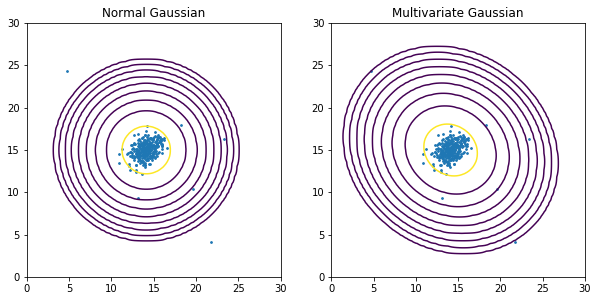

In [6]:
def plot_gaussian_distribution(X):
    gauss1 = GaussianEstimator(normal=True)
    gauss1.fit(X)
    
    step = 100
    xs1, ys1 = np.meshgrid(np.linspace(0,30,step), np.linspace(0,30,step))
    zs1 = gauss1.decision_function(np.dstack((xs1,ys1)).reshape(-1,2)).reshape(step,step)
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.scatter(*X.T, s=3)
    plt.contour(xs1, ys1, zs1, levels=np.logspace(-20,0,10))
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.axis('scaled')
    plt.title('Normal Gaussian')
    
    gauss2 = GaussianEstimator(normal=False)
    gauss2.fit(X)
    
    xs2, ys2 = np.meshgrid(np.linspace(0,30,step), np.linspace(0,30,step))
    zs2 = gauss2.decision_function(np.dstack((xs2, ys2)).reshape(-1,2)).reshape(step,step)
    
    plt.subplot(1,2,2)
    plt.scatter(*X.T, s=3)
    plt.contour(xs2, ys2, zs2, levels=np.logspace(-20,0,10))
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.axis('scaled')
    plt.title('Multivariate Gaussian')

plot_gaussian_distribution(X1)

### Elliptic Envelope Method

In [7]:
def best_elliptic_envelope(X, Xval, yval):
    ps = PredefinedSplit(np.concatenate((np.full(len(X), -1), np.zeros(len(Xval)))))
    gs = GridSearchCV(estimator = MyEllipticEnvelope(),
                      param_grid = {'contamination': np.linspace(0, 0.05, 200)},
                      cv = ps)
                    
    # replace (0,1) classes to (1,-1), to match EllipticEnvelope predictions.
    gs.fit(X = np.vstack((X, Xval)),
           y = np.hstack((np.zeros(len(X)), yval)) * -2 + 1)
    print(f'Elliptic Envelope best score: {gs.best_score_}')
    print(gs.best_params_)
    gs.best_estimator_.fit(X)
    return gs.best_estimator_

Elliptic Envelope best score: 0.8750000000000002
{'contamination': 0.01256281407035176}
MyEllipticEnvelope score: 0.8750000000000001


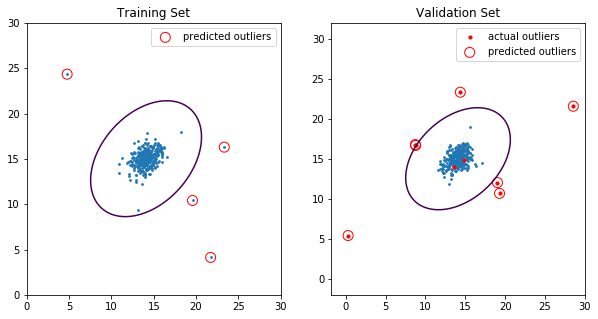

In [11]:
def plot_best_elliptic_envelope(X, Xval, yval):
    ell = best_elliptic_envelope(X, Xval, yval)
    y_pred, yval_pred = ell.predict(X), ell.predict(Xval)
    print(f'MyEllipticEnvelope score: {ell.score(Xval, yval * -2 + 1)}')

    step = 100
    xs, ys = np.meshgrid(np.linspace(0,30,step), np.linspace(0,30,step))
    zs = ell.decision_function(np.dstack((xs,ys)).reshape(-1,2)).reshape(step,step)

    plt.figure(figsize=(10,5))
    
    plt.subplot(121)
    plt.scatter(*X.T, s=3)
    plt.contour(xs,ys,zs, levels=0)
    plt.scatter(*X[y_pred == -1].T, s=100, c='', edgecolors='r', label='predicted outliers');
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.legend()
    plt.title("Training Set")
    
    plt.subplot(122)
    plt.scatter(*Xval.T, s=3)
    plt.contour(xs,ys,zs, levels=0)
    plt.scatter(*Xval[yval == 1].T, s=10, c='r', label='actual outliers');
    plt.scatter(*Xval[yval_pred == -1].T, s=100, c='', edgecolors='r', label='predicted outliers');
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.legend()
    plt.title("Validation Set")
    
    #plt.suptitle('Elliptic Envelope')
    plt.axis('equal')
    
plot_best_elliptic_envelope(X1, X1_val, y1_val)

### Multivariate Gaussian Method

In [9]:
def best_gaussian_estimator(X, Xval, yval, normal=False):
    ps = PredefinedSplit(np.concatenate((np.full(len(X), -1), np.zeros(len(Xval)))))
    pdf = multivariate_normal(mean=X.mean(0), cov=np.cov(X, rowvar=False)).pdf(X)
    gs = GridSearchCV(estimator = GaussianEstimator(normal=normal),
                            param_grid = {'threshold': np.linspace(pdf.min(), pdf.max(), 10000)},
                            cv = ps)
                    
    gs.fit(X = np.vstack((X, Xval)),
           y = np.hstack((np.zeros(len(X)), yval)))
    print(f'Gaussian Estimator best score: {gs.best_score_}')
    print(gs.best_params_)
    gs.best_estimator_.fit(X)
    return gs.best_estimator_

Gaussian Estimator best score: 0.8750000000000002
{'threshold': 3.6130525147814396e-05}
Gaussian Estimator score: 0.8750000000000001


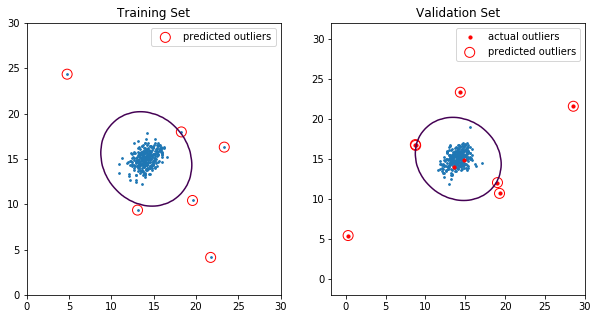

In [10]:
def plot_best_gaussian_estimator(X, Xval, yval, normal=False):
    gauss = best_gaussian_estimator(X, Xval, yval, normal)
    y_pred, yval_pred = gauss.predict(X), gauss.predict(Xval)
    print(f'Gaussian Estimator score: {gauss.score(Xval, yval)}')

    step = 100
    xs, ys = np.meshgrid(np.linspace(0,30,step), np.linspace(0,30,step))
    zs = gauss.decision_function(np.dstack((xs,ys)).reshape(-1,2)).reshape(step,step)
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(121)
    plt.scatter(*X.T, s=3)
    plt.contour(xs,ys,zs, levels=[gauss.threshold])
    plt.scatter(*X[y_pred == 1].T, s=100, c='', edgecolors='r', label='predicted outliers');
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.legend()
    plt.title("Training Set")
    
    plt.subplot(122)
    plt.scatter(*Xval.T, s=3)
    plt.contour(xs,ys,zs, levels=[gauss.threshold])
    plt.scatter(*Xval[yval == 1].T, s=10, c='r', label='actual outliers');
    plt.scatter(*Xval[yval_pred == 1].T, s=100, c='', edgecolors='r', label='predicted outliers');
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.legend()
    plt.title("Validation Set")
    
    #plt.suptitle('Multivariate Gaussian')
    plt.axis('equal')
    
plot_best_gaussian_estimator(X1, X1_val, y1_val, normal=False)

### Univariate Gaussian

In [12]:
norm.pdf(X1, loc=X1.mean(0), scale=X1.std(0)).prod(axis=1);

### Multivariate Gaussian

In [13]:
multivariate_normal.pdf(X1, mean=X1.mean(0), cov=np.cov(X1, rowvar=False));

### High Dimensional Dataset

In [14]:
gauss = best_gaussian_estimator(X2, X2_val, y2_val, normal=False)
np.sum(gauss.predict(X2_val) == 1)

Gaussian Estimator best score: 0.7368421052631579
{'threshold': 3.236645339560881e-19}


9

In [15]:
best_elliptic_envelope(X2, X2_val, y2_val)

Elliptic Envelope best score: 0.7499999999999999
{'contamination': 0.007537688442211056}


MyEllipticEnvelope(assume_centered=False, contamination=0.007537688442211056,
          random_state=None, store_precision=True, support_fraction=None)